In [231]:
import pandas as pd
import sweetviz as sv
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance  # ✅ Fixed import
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [232]:
# Load train and test datasets
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Separate IDs before processing
train_ids = train["id"]
test_ids = test["id"]

# Drop the ID column from both datasets
train.drop(columns=["id"], inplace=True)
test.drop(columns=["id"], inplace=True)

In [233]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         15000 non-null  float64
 1   Drug           8441 non-null   object 
 2   Age            15000 non-null  float64
 3   Sex            15000 non-null  object 
 4   Ascites        8444 non-null   object 
 5   Hepatomegaly   8432 non-null   object 
 6   Spiders        8436 non-null   object 
 7   Edema          15000 non-null  object 
 8   Bilirubin      15000 non-null  float64
 9   Cholesterol    6587 non-null   float64
 10  Albumin        15000 non-null  float64
 11  Copper         8327 non-null   float64
 12  Alk_Phos       8430 non-null   float64
 13  SGOT           8429 non-null   float64
 14  Tryglicerides  6548 non-null   float64
 15  Platelets      14439 non-null  float64
 16  Prothrombin    14974 non-null  float64
 17  Stage          15000 non-null  float64
 18  Status

In [234]:
train.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,15000.000000,15000.000000,15000.000000,6587.000000,15000.000000,8327.000000,8430.000000,8429.000000,6548.000000,14439.000000,14974.000000,15000.000000
mean,1965.807600,19294.668467,1.855687,324.848945,3.521127,75.634995,1628.906749,106.280554,111.154192,253.898975,10.626513,3.027067
std,1247.533088,3672.622854,2.738142,174.154842,0.377559,75.543577,1818.348853,51.911111,51.037848,96.874486,0.723748,0.882186
min,14.000000,309.000000,0.300000,120.000000,1.960000,0.600000,2.940000,0.900000,33.000000,0.300000,9.000000,1.000000
25%,1095.000000,16467.000000,0.600000,239.000000,3.290000,31.000000,720.000000,71.000000,78.000000,183.000000,10.100000,2.000000
50%,1786.000000,19567.000000,0.900000,280.000000,3.580000,52.000000,1072.000000,97.650000,99.000000,249.000000,10.600000,3.000000
75%,2624.000000,22369.000000,1.800000,356.000000,3.770000,88.000000,1644.000000,130.200000,133.000000,312.000000,11.000000,4.000000
max,25976.000000,94754.000000,28.000000,1775.000000,4.640000,598.000000,15112.000000,815.000000,598.000000,3585.000000,18.000000,4.000000


In [235]:
train.isnull().sum()

N_Days              0
Drug             6559
Age                 0
Sex                 0
Ascites          6556
Hepatomegaly     6568
Spiders          6564
Edema               0
Bilirubin           0
Cholesterol      8413
Albumin             0
Copper           6673
Alk_Phos         6570
SGOT             6571
Tryglicerides    8452
Platelets         561
Prothrombin        26
Stage               0
Status              0
dtype: int64

In [236]:
# Mean value imputation
# train["Age"].fillna(train["Age"].mean(), inplace=True)

In [237]:
# # Generate the Sweetviz report
# report = sv.analyze(train)

# # Save the report to an HTML file
# report.show_html('sweetviz_report.html')

In [238]:
# Remove duplicates if any
# train.drop_duplicates(inplace=True)

# drop all missing values in all columns
train = train.dropna()

# Map target variable to 0 and 1
# train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})

In [239]:
# One-hot encode both datasets together to ensure consistent columns
train_encoded = pd.get_dummies(train)
test_encoded = pd.get_dummies(test)

# Align test set with train set to avoid missing or extra columns
train_encoded, test_encoded = train_encoded.align(test_encoded, join="left", axis=1, fill_value=0)


In [240]:
train_encoded.head()    

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Status_C,Status_CL,Status_D
1,2221.0,16216.0,0.6,320.0,3.60,10.0,1282.0,122.45,80.0,358.0,...,False,True,True,False,True,False,False,True,False,False
5,2475.0,16279.0,1.3,376.0,3.61,65.0,591.0,82.15,154.0,70.0,...,False,True,True,False,True,False,False,True,False,False
6,2468.0,19817.0,1.3,317.0,3.61,75.0,671.0,147.25,140.0,228.0,...,False,True,True,False,True,False,False,False,True,False
7,3823.0,10550.0,0.9,317.0,4.04,43.0,843.0,97.65,111.0,336.0,...,False,True,True,False,True,False,False,True,False,False
10,1271.0,20567.0,0.7,263.0,3.95,12.0,657.0,57.35,100.0,252.0,...,False,True,True,False,True,False,False,True,False,False


In [241]:
# Separate target variable (for training only)
X_train = train_encoded.drop(columns=["Status_C", "Status_D", "Status_CL"])  # Drop one-hot encoded status columns
y_train = train_encoded[["Status_C", "Status_D", "Status_CL"]].idxmax(axis=1).astype(str)  # Ensure it's a Series

X_test = test_encoded  # Test data has no target variable

# Ensure y_train is numerical
label_mapping = {col: i for i, col in enumerate(sorted(y_train.unique()))}  # Ensure consistent order
y_train = y_train.map(label_mapping)


X_test = test_encoded  # Test set remains unchanged


In [242]:

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [243]:
# Mean value imputation
# train["Age"].fillna(train["Age"].mean(), inplace=True)

In [244]:
# print shapes
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)


Shape of X_train:  (6264, 27)
Shape of X_test:  (10000, 30)
Shape of y_train:  (6264,)


In [245]:

# Initialize XGBoost classifier with corrected parameters
model = XGBClassifier(
    objective='multi:softprob',  # ✅ Fixed parameter location
    num_class=3,  # ✅ Added this to match softprob
    eval_metric=["merror", "mlogloss"],  # ✅ Correctly set evaluation metrics
    n_estimators=1000,
    # early_stopping_rounds=10 
)

# Train model and evaluate on test set
model.fit(X_train, y_train, eval_set=[(X_train, y_train), ], verbose=True)  # ✅ Fixed eval_set names


[0]	validation_0-merror:0.11446	validation_0-mlogloss:0.81703
[1]	validation_0-merror:0.10824	validation_0-mlogloss:0.65182
[2]	validation_0-merror:0.10792	validation_0-mlogloss:0.54453
[3]	validation_0-merror:0.10616	validation_0-mlogloss:0.47082
[4]	validation_0-merror:0.10313	validation_0-mlogloss:0.41669
[5]	validation_0-merror:0.09754	validation_0-mlogloss:0.37517
[6]	validation_0-merror:0.09563	validation_0-mlogloss:0.34392
[7]	validation_0-merror:0.09323	validation_0-mlogloss:0.31859
[8]	validation_0-merror:0.08940	validation_0-mlogloss:0.29638
[9]	validation_0-merror:0.08685	validation_0-mlogloss:0.27964
[10]	validation_0-merror:0.08461	validation_0-mlogloss:0.26621
[11]	validation_0-merror:0.08269	validation_0-mlogloss:0.25399
[12]	validation_0-merror:0.08158	validation_0-mlogloss:0.24412
[13]	validation_0-merror:0.07663	validation_0-mlogloss:0.23384
[14]	validation_0-merror:0.07471	validation_0-mlogloss:0.22475
[15]	validation_0-merror:0.07168	validation_0-mlogloss:0.21656
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [246]:
# Identify target columns from the test set
status_cols = ["Status_C", "Status_CL", "Status_D"]

# Drop any target-related columns that might be in the test set
X_test = test_encoded.drop(columns=[col for col in status_cols if col in test_encoded], errors='ignore')


In [247]:
# Predict probabilities
y_pred_proba = model.predict_proba(X_test)  # Shape (num_samples, 3)

# Convert probabilities into DataFrame with original target column names
prob_df = pd.DataFrame(y_pred_proba, columns=["Status_A", "Status_B", "Status_C"])

# Add test IDs back to submission
submission = pd.concat([test_ids, prob_df], axis=1)

# Save submission file
submission.to_csv("submission.csv", index=False)



In [248]:
# Define Stratified K-Fold cross-validation
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store evaluation metrics for each fold
accuracy_scores = []
log_losses = []

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\n🟢 Training Fold {fold + 1}/{n_splits}...")

    # Split the data
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Initialize XGBoost classifier
    model = XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric=["merror", "mlogloss"],
        n_estimators=1000,
        early_stopping_rounds=10  # Stops if no improvement
    )

    # Train model
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

    # Predict probabilities
    y_val_pred_proba = model.predict_proba(X_val)

    # Convert probabilities into predicted class labels
    y_val_pred = y_val_pred_proba.argmax(axis=1)

    # Compute accuracy and log loss
    accuracy = accuracy_score(y_val, y_val_pred)
    logloss = log_loss(y_val, y_val_pred_proba)

    # Store metrics
    accuracy_scores.append(accuracy)
    log_losses.append(logloss)

    print(f"✅ Fold {fold + 1} Accuracy: {accuracy:.4f}")
    print(f"✅ Fold {fold + 1} Log Loss: {logloss:.4f}")

# Compute average metrics
avg_accuracy = np.mean(accuracy_scores)
avg_log_loss = np.mean(log_losses)

print("\n📌 Final Cross-Validation Results:")
print(f"✅ Average Accuracy: {avg_accuracy:.4f}")
print(f"✅ Average Log Loss: {avg_log_loss:.4f}")



🟢 Training Fold 1/5...
✅ Fold 1 Accuracy: 0.8723
✅ Fold 1 Log Loss: 0.3598

🟢 Training Fold 2/5...
✅ Fold 2 Accuracy: 0.8532
✅ Fold 2 Log Loss: 0.3978

🟢 Training Fold 3/5...
✅ Fold 3 Accuracy: 0.8819
✅ Fold 3 Log Loss: 0.3276

🟢 Training Fold 4/5...
✅ Fold 4 Accuracy: 0.8500
✅ Fold 4 Log Loss: 0.4018

🟢 Training Fold 5/5...
✅ Fold 5 Accuracy: 0.8626
✅ Fold 5 Log Loss: 0.3829

📌 Final Cross-Validation Results:
✅ Average Accuracy: 0.8640
✅ Average Log Loss: 0.3740


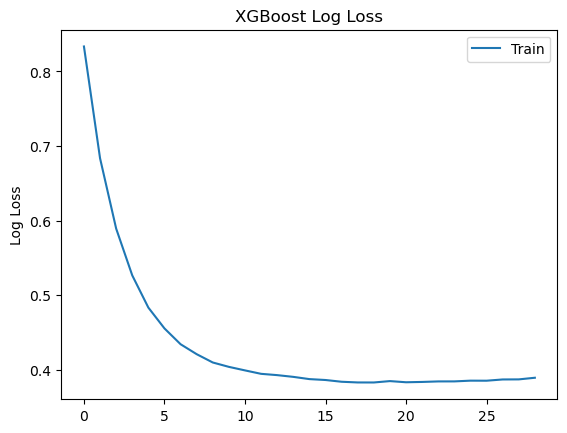

In [249]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
if 'validation_1' in results:
	ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [250]:
# plot classification report
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       0.88      0.94      0.91       849
           1       0.50      0.11      0.18        37
           2       0.82      0.76      0.79       366

    accuracy                           0.86      1252
   macro avg       0.73      0.60      0.63      1252
weighted avg       0.85      0.86      0.85      1252



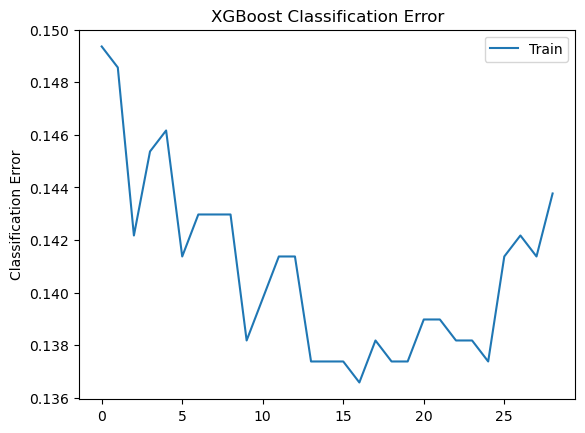

In [251]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
if 'validation_1' in results:
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()



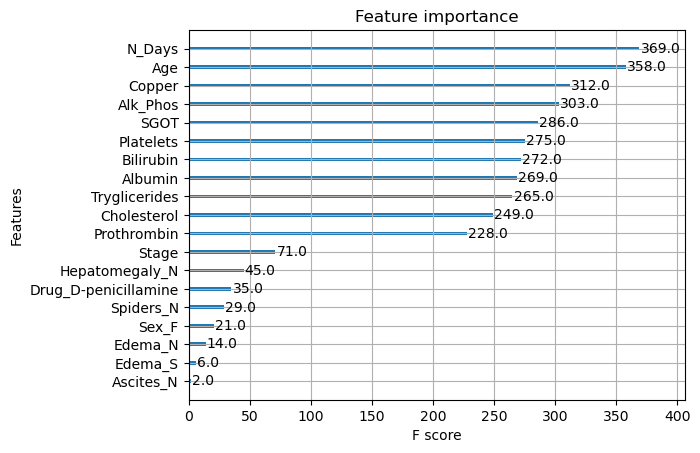

In [252]:

plot_importance(model) 
plt.show()

In [253]:
# import pickle
# pickle.dump(model, open("pima.pickle.dat", "wb")) 
# print("Saved model to: pima.pickle.dat")

# loaded_model = pickle.load(open("pima.pickle.dat", "rb")) 
# print("Loaded model from: pima.pickle.dat")